# **UNet – building an image segmentation model**

After applying convolutional neural networks (CNN) heavily to classification problems now it’s time to explore more about the potential of CNN. Apart from classification, CNN is used today for more advanced problems like image segmentation, object detection, etc. Image segmentation is a process in computer vision where the image is segmented into different segments representing each different class in the image. 

Segmentation helps to identify where objects of different classes are present in an image. UNet is a convolutional neural network architecture that expanded with few changes in the CNN architecture. It was invented to deal with biomedical images where the target is not only to classify whether there is an infection or not but also to identify the area of infection.   

This practice session will demonstrate how we can build an image segmentation model using U-Net that will predict the mask of an object present in an image. The model will localize the object in the image using this method.

To read about UNet-Model Architechture more, please refer [this](https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/) article.

## **Data Set**

The name of the data set is [oxford iiit pet](https://www.kaggle.com/tanlikesmath/the-oxfordiiit-pet-dataset) dataset which was published on Kaggle. If this does not work for you then you can download it directly from this [link](https://drive.google.com/file/d/1KVfrTao_0XzUWLI4-JgGZJOLE0ddjwto/view). The data set is about a different breed of dogs and cats. With each pet name, there are two types of images that would see when you will obtain the data which is one jpg file and another png file. The jpg files contain the image of the respective pet whereas the png file contains the mask image of the pet. You need to closely observe this to identify the mask.

In [1]:
!gdown https://drive.google.com/u/0/uc?id=1KVfrTao_0XzUWLI4-JgGZJOLE0ddjwto

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/u/0/uc?id=1KVfrTao_0XzUWLI4-JgGZJOLE0ddjwto 



## **How to Build UNet Model for Image Segmentation**

After downloading the data set we have saved the images folder to the drive so that we can read them if you want to read that folder locally. First, we need to import the libraries that we require. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd

Once we are done importing the libraries we initialize the directory where the images are stored. After that, we store the list directory in a variable and check what all is present in the list. Use the below code to obtain that and once you print the list you will see something similar to the content shown in the image.

In [8]:
!unzip images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/chihuahua_180.png  
  inflating: images/chihuahua_43.jpg  
  inflating: images/Russian_Blue_8.jpg  
  inflating: images/japanese_chin_165.png  
  inflating: images/american_pit_bull_terrier_91.jpg  
  inflating: images/Ragdoll_156.jpg  
  inflating: images/Birman_147.png   
  inflating: images/Siamese_67.png   
  inflating: images/pomeranian_195.png  
  inflating: images/basset_hound_126.png  
  inflating: images/english_setter_187.png  
  inflating: images/Persian_201.jpg  
  inflating: images/japanese_chin_26.jpg  
  inflating: images/english_setter_178.jpg  
  inflating: images/British_Shorthair_30.jpg  
  inflating: images/Ragdoll_195.png  
  inflating: images/boxer_167.png    
  inflating: images/samoyed_79.png   
  inflating: images/leonberger_117.png  
  inflating: images/Abyssinian_205.jpg  
  inflating: images/leonberger_28.png  
  inflating: images/basset_hound_132.jpg  
  inflating: images/saint_bernard_8

In [2]:
!cd images

In [3]:
lst   = os.listdir('images')
print(lst)

['pomeranian_75.jpg', 'beagle_32.png', 'newfoundland_171.jpg', 'yorkshire_terrier_183.jpg', 'Bengal_103.jpg', 'Sphynx_8.png', 'english_setter_19.jpg', 'Persian_88.jpg', 'english_cocker_spaniel_163.png', 'miniature_pinscher_7.jpg', 'shiba_inu_6.png', 'american_bulldog_42.jpg', 'english_setter_16.png', 'pomeranian_197.png', 'Birman_91.png', 'beagle_92.png', 'english_setter_128.jpg', 'pug_115.png', 'basset_hound_71.png', 'pug_158.jpg', 'german_shorthaired_193.png', 'samoyed_86.jpg', 'staffordshire_bull_terrier_75.png', 'staffordshire_bull_terrier_159.png', 'Persian_197.png', 'keeshond_96.jpg', 'British_Shorthair_51.png', 'japanese_chin_25.jpg', 'beagle_128.png', 'japanese_chin_30.jpg', 'great_pyrenees_67.jpg', 'havanese_104.jpg', 'miniature_pinscher_9.jpg', 'american_pit_bull_terrier_130.jpg', 'Russian_Blue_90.png', 'beagle_191.jpg', 'miniature_pinscher_112.png', 'shiba_inu_208.png', 'Ragdoll_181.jpg', 'keeshond_15.png', 'Abyssinian_225.png', 'saint_bernard_13.png', 'shiba_inu_69.png', 'p

After this, we have created two lists one for storing masks and the other for storing the image. (mask & img). After storing the image and mask we have picked only 1000 images with their corresponding masks. Use the code shown below to do the same.

In [11]:
mask = []
img = []
for filename in lst:
   if filename.endswith('.jpg'):
     img.append(filename)
   if filename.endswith('.png'):
     mask.append(filename)

img.sort()
mask.sort()
img = img[:1000]
masks = mask[:1000]

After sorting has been done we are reading the image and label mask in X and y respectively. We have captured the index of the image file and stored the directory of that index image. After that, we open that image and resize it also then we convert that image into a grayscale image and store its index. We then store the mask of the image corresponding to the index we stored the grayscale image. After that, we give the directory of the mask and read the mask. Finally, we have pre-processed the mask image by resizing it and normalizing the pixel value then stored it at the pre-processed mask image at the output array at the same index position. X[n] stores the image and y[n] stores the corresponding mask.

### **Preprocessing of the image and mask**

In [13]:
y = np.zeros((1000, 28,28), dtype=np.float32)
X = np.zeros((1000,224, 224, 1), dtype=np.float32)

In [14]:
n=0
for file in img:
  index = img.index(file)
  dir_img = os.path.join('images', file)
  input_img = Image.open(dir_img)
  input_img = input_img.resize((224, 224))
  input_img = np.reshape(input_img.convert('L'), (224,224,1)) 
  X[n,:] = input_img
  mask = masks[index]
  dir_mask = os.path.join('images', mask)
  mask_img = cv2.imread(dir_mask)
  mask_img = (mask_img!=2)*1.0  
  mask_img = cv2.resize(mask_img, (28, 28))
  mask_img = 1.0*(mask_img[:,:,0]>0.2)
  y[n, :] = mask_img
  n+1

If you will plot the pre-processed image and mask you will see something similar to the image shown above. The above image shows the pre-processed image as well as its mask. Now we install the pre-trained model for segmentation and load all the useful libraries from that segmentation model as shown in the code below. We will have to add a few convolution libraries as well to add our own custom layers.

TypeError: ignored

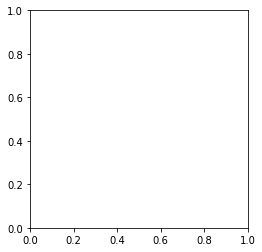

In [18]:
plt.imshow(X[0,:])
plt.show()

In [ ]:
plt.imshow(X[0,:])
plt.show()

In [33]:
!pip install -U --pre segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.7/dist-packages (1.0.1)


In [37]:
import segmentation_models
segmentation_models.set_framework('tf.keras')

In [43]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

We then divide the data into training and testing X, y respectively. After dividing we have imported ResNet as a backbone network and loaded the weights. After this, we pre-process the input and output accordingly.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

###**Building The UNet Model**

We have then imported the U-net model being ResNet as a backbone network and loaded weights of image net. We have then defined the input shape that is expected by the base model and the custom layer that takes that base mode input whose output is then passed to the UNet model. The output of UNet model is then passed to other defined ConvNet layers having activation as ReLU. The final output is then reshaped to 28X28. At last, we have defined the model that takes input (inp) and gives us the output (x_out) using the base_model.


In [45]:
from keras.layers import Reshape
N = X_train.shape[-1]

base_model = Unet('resnet34', encoder_weights='imagenet')

input_base_model = Input(shape=(224, 224, N))

l1 = Conv2D(3, (1, 1))(input_base_model)

out = base_model(l1)

x1 = Conv2D(10, kernel_size =3,strides=2,padding = "same", activation="relu")(out)
x1 = layers.BatchNormalization()

x2= Conv2D(10, kernel_size=3,strides=2,padding = "same", activation="relu")(x1)
x2 =layers.BatchNormalization()

x3 = Conv2D(10, kernel_size=3,strides=2,padding = "same", activation="relu")(x2)
x3 =layers.BatchNormalization()

x4 = Conv2D(1, kernel_size=2,strides=2,padding = "same", activation="relu")(x3)

x_out = Reshape((28,28))(x4)

model = Model(input_base_model, x_out, name=base_model.name)

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_45), but
are not present in its tracked objects:
  <tf.Variable 'bn_data/beta:0' shape=(3,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_48), but
are not present in its tracked objects:
  <tf.Variable 'conv0/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_46), but
are not present in its tracked objects:
  <tf.Variable 'bn0/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'bn0/bet

TypeError: ignored

In [32]:
import keras
help(keras.utils)

Help on package keras.utils in keras:

NAME
    keras.utils

PACKAGE CONTENTS
    all_utils
    control_flow_util
    conv_utils
    data_utils
    dataset_creator
    generic_utils
    io_utils
    kernelized_utils
    kpl_test_utils
    layer_utils
    losses_utils
    metrics_utils
    mode_keys
    multi_gpu_utils
    np_utils
    object_identity
    test_utils
    tf_contextlib
    tf_inspect
    tf_utils
    version_utils
    vis_utils

FILE
    /usr/local/lib/python3.7/dist-packages/keras/utils/__init__.py




We have then defined the function for metric, loss and optimizer that we will be using. Dice coefficient as the metric, loss function as binray_cross_entropy and sgd as an optimizer. After defining everything we have compiled the model and fitted the training and validation data to the model. The code illustration for the same is given below.

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

model.compile(optimizer='sgd', loss=loss, metrics=[dice_coefficient])
model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test, y_test))

Once the model is trained we can then evaluate its performance over the testing set using the code shown below which will give us the least loss and highest accuracy. After evaluation, we have saved the trained model weights by serializing it.  

In [26]:
model.evaluate(x_test, y_test)

NameError: ignored

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

### **Prediction by the UNet model**

After saving the model we made predictions on X_train and X_test using the trained model and stored it. After making predictions we then have defined a function to visualize the prediction made by the model. The function expects input array and output array and the predictions. We have defined k to be none so to randomly pick the images from the training data and for the same index of the picked training image we have taken the mask. We have then defined the figure size and plotted all three that are image, mask, and predicted mask.

In [ ]:
training_pred = model.predict(X_train)
testing_pred = model.predict(X_test)

def prediction(X, y, pred, k=None):
    if k  == ‘None’:
        k = np.random.randint(0, len(X))

    has_mask = y[k].max() > 0

    figure, j = plt.subplots(1, 3, figsize=(20, 20))
    j[0].imshow(X[k, ..., 0])
    if has_mask:
        j[0].contour(y[i].squeeze())
    k[1].imshow(y[i].squeeze())
    k[2].imshow(pred[i].squeeze())
    if has_mask:
        k[2].contour(preds[i].squeeze())

We now plot the images to see the model results. Use the below code to do so

In [ ]:
prediction(X_train, y_train, training_prediction)

The above images show the randomly picked images, corresponding ground truth of the mask and predicted mask by the trained UNet model.

#**Related Articles:**

> * [Unet Image Segmentation Model](https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/)

> * [Comparison of Semantic, Instance and Panoptic Segmentation](https://analyticsindiamag.com/semantic-vs-instance-vs-panoptic-which-image-segmentation-technique-to-choose/)

> * [Panoptic Segmentation](https://analyticsindiamag.com/guide-to-panoptic-segmentation-a-semantic-instance-segmentation-approach/)

> * [PaddleSeg](https://analyticsindiamag.com/guide-to-asymmetric-non-local-neural-networks-using-paddleseg/)

> * [MMDetection](https://analyticsindiamag.com/guide-to-mmdetection-an-object-detection-python-toolbox/)

> * [Facebook D2Go to Mobile](https://analyticsindiamag.com/facebooks-d2go-brings-detectron2-to-mobile/)
